In [1]:
import os
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
# func train
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import built class
from const import *
from early_stopping import EarlyStopping
from improved_model import ThesisEngagement

2025-05-05 07:39:19.633863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746430759.653110   11762 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746430759.659194   11762 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746430759.677614   11762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746430759.677635   11762 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746430759.677636   11762 computation_placer.cc:177] computation placer alr

In [2]:
class EntubeDataset(Dataset):
  def __init__(self, df):
        self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    embedding_data = np.load(os.path.join(EMBEDDED_DATA_DIR, 'agg', row['Id']) + '.npz', allow_pickle=True)
    
    # print((embedding_data['video_embedding'].shape, embedding_data['audio_embedding'].shape, embedding_data['title_embedding'].shape))

    tensor_video = torch.tensor(np.array(list(map(lambda x: list(map(list, x)), embedding_data['video_embedding']))), 
                                dtype=torch.float)
    
    tensor_audio =  torch.tensor(np.array(list(map(list, embedding_data['audio_embedding']))), dtype=torch.float)
        
    tensor_title = torch.tensor(embedding_data['title_embedding'], dtype=torch.float)
    lbl_tensor =  torch.tensor(row[SELECT_LABEL], dtype=torch.long)

    res = ((tensor_title, tensor_video, tensor_audio), lbl_tensor)
    return res

In [3]:
#load data
snapugc_df = pd.read_csv(os.path.join(ROOT_FOLDER, 'prepped_df.csv')) 
# create label
THRESHOLD = 0.5 # [0.3, 0.7]
def get_label(x):
    if type(THRESHOLD) == list:
        if x < THRESHOLD[0]:
            return 0
        elif x > THRESHOLD[1]:
            return 2
        else:
            return 1
    else:
        if x <= THRESHOLD:
            return 0
        else:
            return 1
snapugc_df[SELECT_LABEL] = snapugc_df['NAWP'].apply(get_label) # small ECR is positive

# split data
# train_df = snapugc_df[snapugc_df['Set'] == 'train']
# test_df = snapugc_df[snapugc_df['Set'] == 'test']
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df[SELECT_LABEL])

sub_df = pd.read_csv(os.path.join(ROOT_FOLDER, 'split_video_ids.csv')) 

train_df = snapugc_df[snapugc_df['Id'].isin(sub_df[sub_df['Set'] == 'train']['Id'])]
val_df = snapugc_df[snapugc_df['Id'].isin(sub_df[sub_df['Set'] == 'val']['Id'])]
test_df = snapugc_df[snapugc_df['Id'].isin(sub_df[sub_df['Set'] == 'test']['Id'])]

print(f"Done load data, with (train {len(train_df)}, val {len(val_df)}, test {len(test_df)})")

Done load data, with (train 322, val 65, test 66)


In [4]:
train_dataset = EntubeDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

val_dataset = EntubeDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=True)

test_dataset = EntubeDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

In [5]:
#init to prepare train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = ThesisEngagement()
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

In [7]:
CHECKPOINT_DIR = '/mnt/d/Thesis/Prep/SnapUGC/checkpoints/model_main/label_2/sub_sample'

In [8]:
print('Start testing...')
print('F1_score on test dataset of each epoch: ')
list_model = os.listdir(CHECKPOINT_DIR)
list_model.sort()
max_f1_test = 0
max_acc_test = 0

path = CHECKPOINT_DIR + '/model_min_loss_val.pt'

print("Testing model: ", path)
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, path))
model = ThesisEngagement()
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval().to(device)
pred_test = []
lbl_test = []
with torch.no_grad():
    for embeds, labels in tqdm(val_loader, total=len(val_loader)):
        embeds = tuple(embed.to(device) for embed in embeds)
        labels = labels.to(device)
        outputs = model(embeds)
        lbl_test.append(labels.cpu())
        _, predicts = torch.max(outputs, 1)
        pred_test.append(predicts.cpu())
        
lbl_test = torch.cat(lbl_test, dim=0).numpy()
pred_test = torch.cat(pred_test, dim=0).numpy()

# metrics = classification_report(lbl_test, pred_test)
#print("Done Testing. Classification_report for testing:")
f1 =  f1_score(lbl_test, pred_test, average='micro')
acc_test = accuracy_score(lbl_test, pred_test)
if f1 > max_f1_test:
    max_f1_test = f1
if acc_test > max_acc_test:
    max_acc_test = acc_test
print(f'{path}: F1: {round(f1,4)}, Acc: {round(acc_test,4)}')
    
print('Max f1 can get: ', round(max_f1_test,4))
print('Max acc can get: ', round(max_acc_test,4))
print('Done Testing')

Start testing...
F1_score on test dataset of each epoch: 
Testing model:  /mnt/d/Thesis/Prep/SnapUGC/checkpoints/model_main/label_2/sub_sample/model_min_loss_val.pt


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

/mnt/d/Thesis/Prep/SnapUGC/checkpoints/model_main/label_2/sub_sample/model_min_loss_val.pt: F1: 0.6094, Acc: 0.6094
Max f1 can get:  0.6094
Max acc can get:  0.6094
Done Testing


In [9]:
pred_test

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

<Axes: ylabel='Count'>

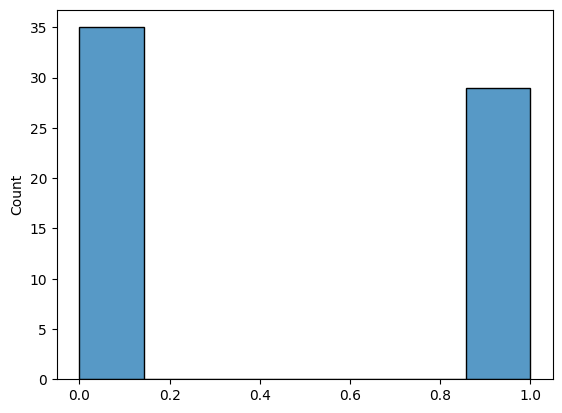

In [10]:
import seaborn as sns


sns.histplot(pred_test)